In [1]:
## %matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import mmh3
from bitarray import bitarray
import time
import random
import sys

# Bloom filter
## Author: Mihail Kalachev

### Abstract

In this paper we examine in detail a specific probabilistic data structure called Bloom filter. We start by examining the differences between a "normal" deterministic data structure and a probabilistic one, what are the pros and cons of each one of them. Then we give a detailed explanation how the Bloom filter works and give a mathematical definition of the probability for error in the Bloom filter. We show in formulas how this probability depends on the size of the bit array, number of hashing functions and number of elements inserted. Then we implement a simple Bloom filter in Python and examine in code how it behaves when we insert different number of elements, change the bit array size or the number of hashing functions on which it is based. We make important observations how each of those changes affects the probability for error. After that we implement a more advanced Bloom filter which automatically determines the bit array size and number of hashing functions based on the desired error probability and expected number of elements to be inserted into it. Based on this implementation we compare the Bloom filter to a simple deterministic data structure, measuring the differences in insert and lookup times as well as the space occupied by both structures. After that we examine a specific use case of Bloom filters in Oracle RDBMS engine and show how it helps decrease SQL query times and significantly reduce the load on the DB engine itself. Finally we make conclusions about what is the use of the Bloom filter.

### What is a Data structure

In computer science, a data structure is a particular way of organizing and storing data in a computer so that it can be accessed and modified efficiently. More precisely, a data structure is a collection of data values, the relationships among them, and the functions or operations that can be applied to the data.

#### Usage
Data structures can implement one or more particular abstract data types (ADT), which specify the operations that can be performed on a data structure and the computational complexity of those operations. In comparison, a data structure is a concrete implementation of the space provided by an ADT.

Different kinds of data structures are suited to different kinds of applications, and some are highly specialized to specific tasks. For example, relational databases commonly use B-tree indexes for data retrieval, while compiler implementations usually use hash tables to look up identifiers.

Data structures provide a means to manage large amounts of data efficiently for uses such as large databases and internet indexing services. Usually, efficient data structures are key to designing efficient algorithms. Some formal design methods and programming languages emphasize data structures, rather than algorithms, as the key organizing factor in software design.

#### Implementation
Data structures are generally based on the ability of a computer to fetch and store data at any place in its memory, specified by a pointer—a bit string, representing a memory address, that can be itself stored in memory and manipulated by the program. Thus, the array and record data structures are based on computing the addresses of data items with arithmetic operations; while the linked data structures are based on storing addresses of data items within the structure itself. Many data structures use both principles, sometimes combined in non-trivial ways (as in XOR linking).

The implementation of a data structure usually requires writing a set of procedures that create and manipulate instances of that structure. The efficiency of a data structure cannot be analyzed separately from those operations. This observation motivates the theoretical concept of an abstract data type, a data structure that is defined indirectly by the operations that may be performed on it, and the mathematical properties of those operations (including their space and time cost).

#### Examples
There are numerous types of data structures, generally built upon simpler primitive data types:

* An array is a number of elements in a specific order, typically all of the same type. Elements are accessed using an integer index to specify which element is required (Depending on the language, individual elements may either all be forced to be the same type, or may be of almost any type). Typical implementations allocate contiguous memory words for the elements of arrays (but this is not always a necessity). Arrays may be fixed-length or resizable.
* A linked list (also just called list) is a linear collection of data elements of any type, called nodes, where each node has itself a value, and points to the next node in the linked list. The principal advantage of a linked list over an array, is that values can always be efficiently inserted and removed without relocating the rest of the list. Certain other operations, such as random access to a certain element, are however slower on lists than on arrays.
* A hash table (hash map) is a data structure which implements an associative array abstract data type, a structure that can map keys to values. A hash table uses a hash function to compute an index into an array of buckets or slots, from which the desired value can be found.

<img src="Hash_table_example.png" />

### Probabilistic data structures

When processing large data sets, we often want to do some simple checks, such as number of unique items, most frequent items, and whether some items exist in the data set. The common approach is to use some kind of deterministic data structure like HashSet or Hashtable for such purposes. But when the data set we are dealing with becomes very large, such data structures are simply not feasible because the data is too big to fit in the memory. It becomes even more difficult for streaming applications which typically require data to be processed in one pass and perform incremental updates.

Probabilistic data structures are a group of data structures that are extremely useful for big data and streaming applications. Generally speaking, these data structures use hash functions to randomize and compactly represent a set of items. Collisions are ignored but errors can be well-controlled under certain threshold. Comparing with error-free approaches, these algorithms use much less memory and have constant query time. They usually **support union and intersection operations and therefore can be easily parallelized**.

Their probabilistic behavior lies in the fact that these data structures do not provide an absolutely correct answer in 100% of all cases. Instead there is a **probability that the answer to your question might be wrong**. This probability can  usually be pre-calculated beforehand based on different parameters of the structure like its size, number of hashing functions used, etc. Usually you have a choice to reduce the probability of an error by increasing the size of the structure. So it is always a **trade-off between size and error rate** which should be chosen appropriately in each scenario based on the requirements.

**Advantages** (compared to deterministic data structures):
* smaller size of the structure
* faster operations and processing of elements
* work well with huge data sets

**Disadvantages**:
* not precise, probability of an error

### Bloom filter

A Bloom filter is a space-efficient probabilistic data structure, conceived by Burton Howard Bloom in 1970, that is used to test whether an element is a member of a set. **False positive matches are possible, but false negatives are not** – in other words, a query returns either "possibly in set" or "definitely not in set". Elements can be added to the set, but not removed (though this can be addressed with a "counting" filter); **the more elements that are added to the set, the larger the probability of false positives**.

#### Algorithm description

An empty Bloom filter is a bit array of $m$ bits, all set to 0. There must also be $k$ different hash functions defined, each of which maps or hashes some set element to one of the $m$ array positions, generating a uniform random distribution. Typically, $k$ is a constant, much smaller than $m$, which is proportional to the number of elements to be added; **the precise choice of $k$ and the constant of proportionality of $m$ are determined by the intended false positive rate of the filter**.

To add an element, feed it to each of the $k$ hash functions to get $k$ array positions. Set the bits at all these positions to 1.

To query for an element (test whether it is in the set), feed it to each of the $k$ hash functions to get $k$ array positions. If any of the bits at these positions is 0, the element is definitely not in the set – if it were, then all the bits would have been set to 1 when it was inserted. If all are 1, then either the element is in the set, or the bits have by chance been set to 1 during the insertion of other elements, resulting in a false positive. In a simple Bloom filter, there is no way to distinguish between the two cases, but more advanced techniques can address this problem.

The requirement of designing $k$ different independent hash functions can be prohibitive for large $k$. For a good hash function with a wide output, there should be little if any correlation between different bit-fields of such a hash, so this type of hash can be used to generate multiple "different" hash functions by slicing its output into multiple bit fields. Alternatively, one can pass $k$ different initial values (such as 0, 1, ..., $k$ − 1) to a hash function that takes an initial value; or add (or append) these values to the key. For larger $m$ and/or $k$, independence among the hash functions can be relaxed with negligible increase in false positive rate. 

Removing an element from this simple Bloom filter is impossible because false negatives are not permitted. An element maps to $k$ bits, and although setting any one of those $k$ bits to zero suffices to remove the element, it also results in removing any other elements that happen to map onto that bit. Since there is no way of determining whether any other elements have been added that affect the bits for an element to be removed, clearing any of the bits would introduce the possibility for false negatives.

One-time removal of an element from a Bloom filter can be simulated by having a second Bloom filter that contains items that have been removed. However, false positives in the second filter become false negatives in the composite filter, which may be undesirable. In this approach re-adding a previously removed item is not possible, as one would have to remove it from the "removed" filter.

It is often the case that all the keys are available but are expensive to enumerate (for example, requiring many disk reads). When the false positive rate gets too high, the filter can be regenerated; this should be a relatively rare event.

<img src="Bloom_filter.png" height="400" width="400"/>

In the picture above, we can see example of a Bloom filter, representing the set {$x, y, z$}. The colored arrows show the positions in the bit array that each set element is mapped to. The element $w$ is not in the set {$x, y, z$}, because it hashes to one bit-array position containing 0. For this figure, $m$ = 18 and $k$ = 3.

#### Space and time advantages

While risking false positives, **Bloom filters have a strong space advantage over other data structures for representing sets**, such as self-balancing binary search trees, hash tables, or simple arrays or linked lists of the entries. Most of these require storing at least the data items themselves, which can require anywhere from a small number of bits, for small integers, to an arbitrary number of bits, such as for strings. However, Bloom filters do not store the data items at all, and a separate solution must be provided for the actual storage. Linked structures incur an additional linear space overhead for pointers. A Bloom filter with 1% error and an optimal value of $k$, in contrast, requires only about 9.6 bits per element, regardless of the size of the elements. This advantage comes partly from its compactness, inherited from arrays, and partly from its probabilistic nature. The 1% false-positive rate can be reduced by a factor of ten by adding only about 4.8 bits per element.

However, if the number of potential values is small and many of them can be in the set, the Bloom filter is easily surpassed by the deterministic bit array, which requires only one bit for each potential element. Note also that hash tables gain a space and time advantage if they begin ignoring collisions and store only whether each bucket contains an entry; in this case, they have effectively become Bloom filters with $k$ = 1.

**Bloom filters also have the unusual property that the time needed either to add items or to check whether an item is in the set is a fixed constant, O($k$)**, completely independent of the number of items already in the set. No other constant-space set data structure has this property, but the average access time of sparse hash tables can make them faster in practice than some Bloom filters. In a hardware implementation, however, the Bloom filter shines because its $k$ lookups are independent and can be parallelized.

To understand its space efficiency, it is instructive to compare the general Bloom filter with its special case when $k$ = 1. If $k$ = 1, then in order to keep the false positive rate sufficiently low, a small fraction of bits should be set, which means the array must be very large and contain long runs of zeros. The information content of the array relative to its size is low. The generalized Bloom filter ($k$ greater than 1) allows many more bits to be set while still maintaining a low false positive rate; if the parameters ($k$ and $m$) are chosen well, about half of the bits will be set, and these will be apparently random, minimizing redundancy and maximizing information content.

#### Probability of false positives

Assume that a hash function selects each array position with equal probability. If $m$ is the number of bits in the array, the probability that a certain bit is not set to 1 by a certain hash function during the insertion of an element is

$$ 1 - \frac{1}{m} $$

If $k$ is the number of hash functions, the probability that the bit is not set to 1 by any of the hash functions is

$$ \left (1 - \frac{1}{m}\right )^{k} $$

If we have inserted $n$ elements, the probability that a certain bit is still 0 is

$$ \left (1 - \frac{1}{m}\right )^{kn} $$

the probability that it is 1 is therefore

$$ 1 - \left (1-\frac{1}{m}\right)^{kn} $$

Now test membership of an element that is not in the set. Each of the $k$ array positions computed by the hash functions is 1 with a probability as above. The probability of all of them being 1, which would cause the algorithm to erroneously claim that the element is in the set, is often given as

$$ \left(1-\left[1-\frac {1}{m}\right]^{kn}\right)^{k} \approx \left(1-e^{\frac{-kn}{m}}\right)^{k} $$

This is not strictly correct as it assumes independence for the probabilities of each bit being set. However, assuming it is a close approximation we have that the probability of false positives decreases as $m$ (the number of bits in the array) increases, and increases as $n$ (the number of inserted elements) increases.

An alternative analysis arriving at the same approximation without the assumption of independence is given by Mitzenmacher and Upfal.

##### Optimal number of hash functions

The number of hash functions, $k$, must be a positive integer. Putting this constraint aside, for a given $m$ and $n$, the value of $k$ that minimizes the false positive probability is

$$ k={\frac{m}{n}}\ln 2 $$

The required number of bits, $m$, given $n$ (the number of inserted elements) and a desired false positive probability $p$ (and assuming the optimal value of $k$ is used) can be computed by substituting the optimal value of $k$ in the probability expression above:

$$ p=\left(1-e^{-({\frac {m}{n}}\ln 2){\frac {n}{m}}}\right)^{{\frac {m}{n}}\ln 2} $$

which can be simplified to:

$$ \ln p=-{\frac {m}{n}}\left(\ln 2\right)^{2} $$

This results in:

$$ m=-{\frac {n\ln p}{(\ln 2)^{2}}} $$

So the optimal number of bits per element is

$$ {\frac {m}{n}}=-{\frac {\log _{2}p}{\ln 2}}\approx -1.44{\log _{2}p} $$

with the corresponding number of hash functions $k$ (ignoring integrality):

$$ k=-{\frac {\ln p}{\ln 2}}=-{\log _{2}p}. $$

This means that for a given false positive probability $p$, the length of a Bloom filter $m$ is proportionate to the number of elements being filtered $n$ and the required number of hash functions only depends on the target false positive probability $p$.

The formula $ m=-{\frac {n\ln p}{(\ln 2)^{2}}} $ is approximate for three reasons. First, and of least concern, it approximates $ 1-{\frac {1}{m}} $ as $ e^{-{\frac {1}{m}}} $, which is a good asymptotic approximation (i.e., which holds as $ m \to \infty $). Second, of more concern, it assumes that during the membership test the event that one tested bit is set to 1 is independent of the event that any other tested bit is set to 1. Third, of most concern, it assumes that $ k={\frac {m}{n}}\ln 2 $ is fortuitously integral.

Goel and Gupta, however, give a rigorous upper bound that makes no approximations and requires no assumptions. They show that the false positive probability for a finite Bloom filter with m bits ( $ m>1 $), $n$ elements, and $k$ hash functions is at most

$$ \left(1-e^{-{\frac {k(n+0.5)}{m-1}}}\right)^{k} $$

This bound can be interpreted as saying that the approximate formula $ \left(1-e^{-{\frac {kn}{m}}}\right)^{k} $ can be applied at a penalty of at most half an extra element and at most one fewer bit.

#### Approximating the number of items in a Bloom filter

Swamidass & Baldi (2007) showed that the number of items in a Bloom filter can be approximated with the following formula,

$$ n^{*}=-{\frac {m}{k}}\ln \left[1-{\frac {X}{m}}\right] $$

where $ n^{*} $ is an estimate of the number of items in the filter, $m$ is the length (size) of the filter, $k$ is the number of hash functions, and $X$ is the number of bits set to one.

#### Interesting properties

* Unlike a standard hash table, a Bloom filter of a fixed size can represent a set with an arbitrarily large number of elements; adding an element never fails due to the data structure "filling up". However, the false positive rate increases steadily as elements are added until all bits in the filter are set to 1, at which point all queries yield a positive result.
* Union and intersection of Bloom filters with the same size and set of hash functions can be implemented with bitwise OR and AND operations respectively. The union operation on Bloom filters is lossless in the sense that the resulting Bloom filter is the same as the Bloom filter created from scratch using the union of the two sets. The intersect operation satisfies a weaker property: the false positive probability in the resulting Bloom filter is at most the false-positive probability in one of the constituent Bloom filters, but may be larger than the false positive probability in the Bloom filter created from scratch using the intersection of the two sets.

### Simple implementation and false positive probability tests

Now that we know how things look like in theory, let's try implementing a simple bloom filter

In [3]:
class BloomFilter:
    '''
    A simple implementation of a Bloom filter, based on the 
    murmur3 hash function
    '''
    def __init__(self, array_size, hash_count):
        '''
        Create a bloom filter array 
        array_size : int
            Size of the bit array
        hash_count : int
            Number of hashing functions
        '''
        self.array_size = array_size
        self.hash_count = hash_count
        
        # Create the bit array of the given size
        self.bit_array = bitarray(array_size)
        
        # Initialize all bit array elements with zeros
        self.bit_array.setall(0)
        
    def add(self, item):
        '''
        Add an element to the bloom filter
        '''
        
        # Apply all hash functions to the element inserted
        # seeding them with the number of the hash function (1, 2, 3, etc...)
        # And then return as a result the remainder of the devision of
        # the hash output and the number of bit array elements
        # Setting the corresponding bit to 1
        for seed in range(self.hash_count):
            self.bit_array[mmh3.hash(item, seed) % self.array_size] = 1
            
    def lookup(self, item):
        '''
        Search for an element in the filter
        '''
        
        # Apply all hash functions with the same seed as before to
        # the element being checked. If all resulting bits are 1, return True,
        # else return False
        for seed in range(self.hash_count):
            if self.bit_array[mmh3.hash(item, seed) % self.array_size] == 0:
                return False
        return True

Now let's create a function that generates a list of strings with a given list size, string size and alphabet. We will use this function to generate the lists for the Bloom filter tests later.

In [4]:
def StringGenerator(array_size=100, word_size=32, chars=list('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz1234567890')):
    '''
    Generate a list of strings
    
    array_size : int
        Size of the resulting list
    word_size : int
        length of the strings in the list
    chars : list
        A list of symbols to use in the string generation
    '''
    
    np_codes = np.random.choice(chars, [array_size, word_size])
    return ["".join(np_codes[i]) for i in range(len(np_codes))]

Now that we are done with the basic definitions, let's create a function that for given different bit array sizes, number of hash functions and size of the input string list, does the following:
* Generate a list called `item_array` of random strings with the given size. This list will "feed" our bloom filter with data
* Generate another list called `words_to_test`. Half of this list will contain items from `item_array`, the other half will be randomly generated strings. This list will be used to lookup words from it in our bloom filter. We want some of them to be found in the filter and some of them to not be found, that is why we generated it with words from `item_array` and with words that are not there. Shuffle this list to achive better randomization of results
* Create a bloom filter with the given input parameters
* Fill the bloom filter with items from `item_array` in batches
* After each batch inserted into the filter, lookup words from `words_to_test` in the filter. Do this for the given number of attempts (10000 words by default to achive better approximation results)
* Each word that is not in the original `item_array`, but the bloom filter reports it as positive result, is a false positive. Count all false positives and estimate the error rate numerically.
* Plot the numerical error rate per cent
* In the same graph, plot the estimated mathematical probability for error as a funciton of the number of elements present in the filter, when the number of hash functions $k$ and the size of the bit array $m$ are fixed:
$ \left(1-e^{\frac{-kn}{m}}\right)^{k} $

In [5]:
def plot_probability_error(bit_array_size = 1000, dict_array_size = 1000, batch_steps = 10, word_size = 32, hash_function_count = 5, words_lookup_per_batch = 10000):
    '''
    Function used to plot the actual false positive rate of a bloom filter
    compared to the estimated false posttive rate
    
    bit_array_size : int
        Size of the bit array
    dict_array_size : int
        Number of elements to insert in the bloom filter
    batch_steps : int
        Number of steps in which to insert the whole dict_array_size into the bloom filter
    word_size : int
        Length of the dict_array_size elements
    hash_function_count : int
        Number of hash functions
    words_lookup_per_batch : int
        How many words to lookup in the bloom filter in each batch step iteration
    '''
    
    # List to insert into the bloom filter
    item_array = StringGenerator(dict_array_size, word_size)
    
    # List that we will use to probe into the filter
    words_to_test = item_array[:dict_array_size//2] + StringGenerator(dict_array_size//2, word_size)
    # Shuffle the probe list
    random.shuffle(words_to_test)
    
    # Create the bloom filter with the given input parameters
    bloomf = BloomFilter(bit_array_size, hash_function_count)
    
    false_positive = 0
    true_negative = 0
    
    try_count = words_lookup_per_batch
    
    # Calculate the batch size based on the whole input list size and the given number of steps
    batch_size = dict_array_size // batch_steps
    
    # Numpy vector arrays that we will use to plot our results
    elements_x_axis = np.array([])
    elements_y_axis = np.array([])
    
    # Fill the bloom filter with data in batches
    for batch_step in range(batch_steps):
        for batch_iterator in range(batch_size):
            bloomf.add(item_array[batch_iterator + batch_size * batch_step])
            
        false_positive = 0
        true_negative = 0
            
        # For each batch lookup "try_count" number of words and calculate the false positive rate
        for i in range(try_count):
            random_index = random.randint(0, len(words_to_test) - 1)
            if (words_to_test[random_index] not in item_array[:batch_step * batch_size + batch_size]):
                true_negative += 1
                if (bloomf.lookup(words_to_test[random_index]) == True):
                    false_positive += 1
                
        # Record the false positive rate in our NumPy arrays for visualization
        elements_x_axis = np.append(elements_x_axis, batch_size + batch_size * batch_step)
        elements_y_axis = np.append(elements_y_axis, (false_positive / true_negative) * 100)
    
    # Calculate the error probability function over the number of elements inserted.
    # Multiply the result by 100 to make it look like "per cent expected errors" and not like "probability for error"
    x = np.linspace(min(elements_x_axis), max(elements_x_axis), 1000)
    y = np.power(1 - np.power(np.e, (-1 * hash_function_count * x) / bit_array_size), hash_function_count) * 100
        
    ax = plt.gca()
    ax.spines["bottom"].set_position("zero")
    ax.spines["left"].set_position("zero")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
        
    plt.xlabel("Number of elements inserted")
    plt.ylabel("False positive %")
            
    min_int_x = 0
    max_int_x = np.max(elements_x_axis)
    min_int_y = 0
    max_int_y = max(np.max(elements_y_axis), np.max(y))
        
    ax.set_xlim(min_int_x, max_int_x + 100)
    ax.set_ylim(min_int_y, max_int_y + max_int_y/20)
    
    # Plot the actual error rate as discrete points
    plt.scatter(elements_x_axis, elements_y_axis, color = "blue", label='numeric')
    plt.vlines(elements_x_axis, 0, elements_y_axis, color = "blue", linewidth = 5, alpha = 0.5)
    
    # Plot the error probability function
    plt.plot(x,y, color="orange", label='mathematical')
    
    plt.title("Empirical proof of probability formula k = " + str(hash_function_count) + ", m = " + str(bit_array_size))
    plt.legend(loc='upper left')
    
    plt.show()

Now that our nice function is ready, let's test it. We test it with a fixed input array of 1000 elements, but **we increase the size of the bloom filter bit array** to see how this influences the false positive error rate

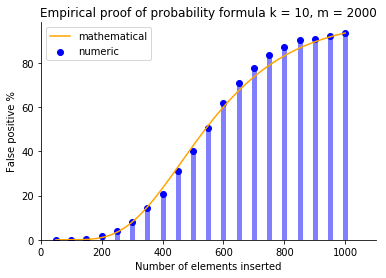

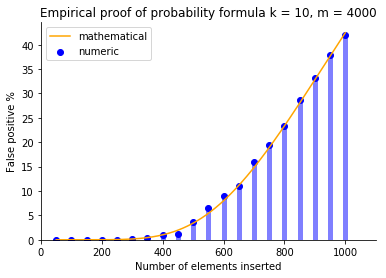

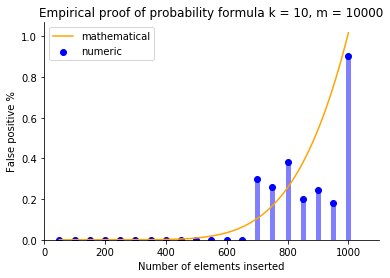

In [16]:
plot_probability_error(bit_array_size=2000, dict_array_size=1000, batch_steps=20, word_size=32, hash_function_count=10, words_lookup_per_batch=10000)
plot_probability_error(bit_array_size=4000, dict_array_size=1000, batch_steps=20, word_size=32, hash_function_count=10, words_lookup_per_batch=10000)
plot_probability_error(bit_array_size=10000, dict_array_size=1000, batch_steps=20, word_size=32, hash_function_count=10, words_lookup_per_batch=10000)

As we can see, the **error rate decreases with the increase of the bloom filter bit array size**. Now let's play the same game, but instead of increasing the bit array size, let's fix it somewhere in the middle (5000 elements) and play with the hash functions count to see what happens with the error:

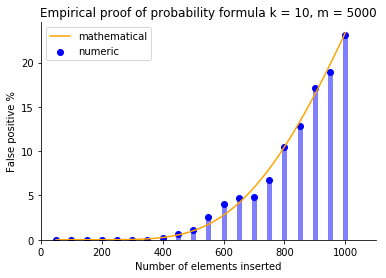

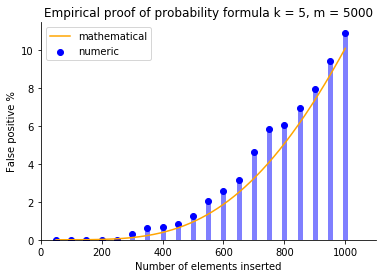

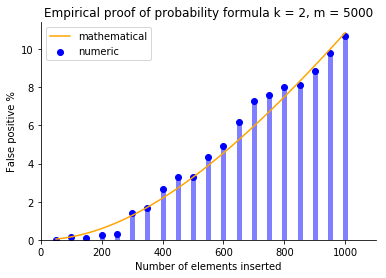

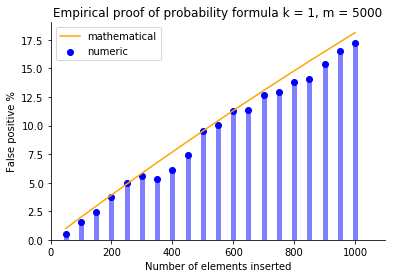

In [7]:
plot_probability_error(bit_array_size=5000, dict_array_size=1000, batch_steps=20, word_size=32, hash_function_count=10)
plot_probability_error(bit_array_size=5000, dict_array_size=1000, batch_steps=20, word_size=32, hash_function_count=5)
plot_probability_error(bit_array_size=5000, dict_array_size=1000, batch_steps=20, word_size=32, hash_function_count=2)
plot_probability_error(bit_array_size=5000, dict_array_size=1000, batch_steps=20, word_size=32, hash_function_count=1)

The first 2 cases show that **when we decrease the number of hash functions, the error rate is again reduced**, but not by that much as when we play with the bit array size. The third and fourth example are however baffling. **The error rate is actually increased when we reduce the number of hash functions to 1**. This may seem strange, but we can explain it, by plotting the error probability as a function of the number of hash functions:

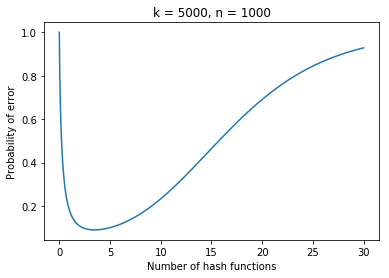

In [8]:
x = np.linspace(0, 30, 2000)
y = np.power(1 - np.power(np.e, (-1 * x * 1000) / 5000), x)

plt.title("k = 5000, n = 1000")
plt.xlabel("Number of hash functions")
plt.ylabel("Probability of error")
plt.plot(x,y)
plt.show()

As you can see, indeed the error probability is reduced when we reduce the hash functions count, but if we reduce them too much, the error rate rises again. This is even more obvious if our bit array size was much bigger compared to the input list:

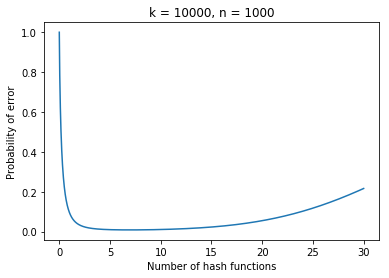

In [9]:
x = np.linspace(0, 30, 2000)
y = np.power(1 - np.power(np.e, (-1 * x * 1000) / 10000), x)

plt.title("k = 10000, n = 1000")
plt.xlabel("Number of hash functions")
plt.ylabel("Probability of error")
plt.plot(x,y)
plt.show()

Finally let's see if we can use the probability calculations from the beginning to implement a perfect bloom filter, which automatically determines the bit array size and the number of hash functions based on how many elements we intend to put in it and the false positive error rate that we desire:

Computed size of bit array: 6235
Computed number of hash functions: 4


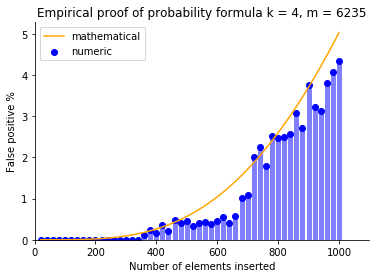

In [10]:
# Prоbability = 0.05
# Error rate of less than 5%
p = 0.05

# Number of elements to insert = 1000
n = 1000

# Automatically calculated bit array size
m = int(-(n * math.log(p))/(math.log(2)**2))

# Automatically calculated number of hash functions
k = int(-math.log(p) / math.log(2))

print('Computed size of bit array: ' + str(m))
print('Computed number of hash functions: ' + str(k))

plot_probability_error(bit_array_size=m, dict_array_size=n, batch_steps=50, word_size=32, hash_function_count=k)

**Success!** The error rate is indeed 5% what we have "ordered" (probability for error = 0.05)

#### Conclusion:
We managed to prove numerically that our false positive error probability estimations were correct. We also showed how the number of elements inserted in the bloom filter $n$, the size of the bit array of the bloom filter $m$, the number of hash functions $k$ and the probability for false positive result $p$ are closely interrelated and modifying any one of those parameters has an impact on the rest.

### Advanced Bloom filter implementation and comparison to a deterministic data structure

Based on our conclusion above, we can use the mathematical probability estimation to implement a bloom filter, where we give it only the probability for error that we want to achive and the number of elements we plan to insert into it, while we automatically calculate the bit array size and number of hash functions:

In [11]:
class BloomFilterAdvanced:
    '''
    An advanced implementation of a Bloom filter, based on the 
    murmur3 hash function, where we calculate bit array size and
    hash function count automatically
    '''
    def __init__(self, items_count, fp_prob):
        '''
        Filter constructor
        
        items_count : int
            How many items do you plan to put in the filter
        fp_prob : float
            What is the false positive probability that you want to design into the filter        
        '''
        # false positive probability
        self.fp_prob = fp_prob
 
        # Size of bit array to use
        self.size = self.get_array_size(items_count,fp_prob)
 
        # number of hash functions to use
        self.hash_count = self.get_hash_count(self.size,items_count)
 
        # Bit array of given size
        self.bit_array = bitarray(self.size)
 
        # initialize all bits as 0
        self.bit_array.setall(0)
        
    def add(self, item):
        '''
        Add an item into the filter
        '''
        
        # Apply all hash functions to the element inserted
        # seeding them with the number of the hash function (1, 2, 3, etc...)
        # And then return as a result the remainder of the devision of
        # the hash output and the number of bit array elements
        # Setting the corresponding bit to 1
        for seed in range(self.hash_count):
            self.bit_array[mmh3.hash(item, seed) % self.size] = 1
           
    def lookup(self, item):
        '''
        Search for an element in the filter
        '''
        
        # Apply all hash functions with the same seed as before to
        # the element being checked. If all resulting bits are 1, return True,
        # else return False
        for seed in range(self.hash_count):
            if self.bit_array[mmh3.hash(item, seed) % self.size] == 0:
                return False
        return True
    
    def get_array_size(self,n,p):
        '''
        Return the size of the bit array(m) to be used, using the
        following formula:
        m = -(n * lg(p)) / (lg(2)^2)
        n : int
            number of items expected to be stored in filter
        p : float
            False Positive probability in decimal
        '''
        m = -(n * math.log(p))/(math.log(2)**2)
        return int(m)
 
    def get_hash_count(self, m, n):
        '''
        Return the hash function count(k) to be used, using the
        following formula
        k = (m/n) * lg(2)
 
        m : int
            size of bit array
        n : int
            number of items expected to be stored in filter
        '''
        k = (m/n) * math.log(2)
        return int(k)

Good. Now that we have implemented our advanced Bloom filter, lets create another function that for a given size of the input string list and probability for error does the following:

* Generate a list called `item_array` of random strings with the given size. This list will "feed" our structures with data  just like we did before
* Generate another list called `words_to_test`. Half of this list will contain items from `item_array`, the other half will be randomly generated strings. This list will be used to lookup words from it in our data structures. We want some of them to be found in them and some of them to not be found, that is why we generated it with words from `item_array` and with words that are not there. Shuffle this list to achive better randomization of results
* Create a bloom filter with the given input parameters (input string size, probability for error)
* Create a python list
* Fill the bloom filter and python list with items from `item_array` in batches
* After each batch record the time it took to insert it into each structure
* After each batch inserted, lookup words from `words_to_test` **both in the filter and in the Python list** . Do this for the given number of attempts (10000 words by default to achive better approximation results)
* Record the sum of all search times for each batch for each data structure
* After each batch inserted, record the size of both data structures
* Finally plot all corresponding results in 3 separate graphs to compare results

In [12]:
def plot_filter_comparison(dict_array_size = 1000, batch_steps = 10, word_size = 32, fp_probability = 0.05, words_lookup_per_batch = 100):
    '''
    Function used to plot the comparison between a bloom filter and a deterministic data structure
    regarding insert times, lookup times and structure size
    
    dict_array_size : int
        Size of the input string list
    batch_steps : int
       Number of steps in which to insert the whole dict_array_size into the structures
    word_size : int
        Length of the dict_array_size elements
    fp_probability : float
        Probability for a false positive result that we want to achive for the bloom filter
    words_lookup_per_batch : int
        How many words to lookup in the structures in each batch step iteration
    '''
    
    # List to insert into the structures
    item_array = StringGenerator(dict_array_size, word_size)
    
    # List that we will use to probe into the structures
    words_to_test = item_array[:dict_array_size//2] + StringGenerator(dict_array_size//2, word_size)
    # Shuffle the probe list
    random.shuffle(words_to_test)
    
    # Create the bloom filter with the given input parameters
    bloomf = BloomFilterAdvanced(dict_array_size, fp_probability)
    # Create the python list
    test = []
    
    try_count = words_lookup_per_batch
    
    # Calculate the batch size based on the whole input list size and the given number of steps
    batch_size = dict_array_size // batch_steps
    
    # Numpy vector arrays that we will use to plot our results
    elements_x_axis = np.array([])
    
    insert_times_bloom = np.array([])
    insert_times_test = np.array([])
    
    lookup_times_bloom = np.array([])
    lookup_times_test = np.array([])
    
    size_bloom = np.array([])
    size_test = np.array([])
    
    accum_lookup_time_bloom = 0
    accum_lookup_time_test = 0
    
    time_begin = time.time()
    time_end = time.time()
    
    i = True
    
    for batch_step in range(batch_steps):
        
        # Fill the structures with data in batches and record the insert times
        time_begin = time.time()
        for batch_iterator_bloom in range(batch_size):
            bloomf.add(item_array[batch_iterator_bloom + batch_size * batch_step])
        time_end = time.time()
        
        insert_times_bloom = np.append(insert_times_bloom, time_end - time_begin)
                
        time_begin = time.time()
        for batch_iterator_test in range(batch_size):
            test.append(item_array[batch_iterator_test + batch_size * batch_step])
        time_end = time.time()

        insert_times_test = np.append(insert_times_test, time_end - time_begin)
        
        accum_lookup_time_bloom = 0
        accum_lookup_time_test = 0
        
        # For each batch lookup "try_count" number of words and record the cumulative batch lookup times
        for i in range(try_count):
            # choose a random word each time
            random_index = random.randint(0, len(words_to_test) - 1)

            time_begin = time.time()
            i = bloomf.lookup(words_to_test[random_index])
            time_end = time.time()
            accum_lookup_time_bloom += time_end - time_begin
            
            time_begin = time.time()
            i = (words_to_test[random_index] in test)
            time_end = time.time()
            accum_lookup_time_test += time_end - time_begin
            
        # Record the lookup times
        lookup_times_bloom = np.append(lookup_times_bloom, accum_lookup_time_bloom)
        lookup_times_test = np.append(lookup_times_test, accum_lookup_time_test)
        
        # Record the structure sizes in KB
        size_bloom = np.append(size_bloom, int(sys.getsizeof(bloomf.bit_array) / 1024))
        size_test = np.append(size_test, int(sys.getsizeof(test) / 1024))
        
        elements_x_axis = np.append(elements_x_axis, batch_size + batch_size * batch_step)
    
    min_int_x = 0
    max_int_x = np.max(elements_x_axis)
    min_int_y = 0
    
    ax = plt.gca()
    ax.spines["bottom"].set_position("zero")
    ax.spines["left"].set_position("zero")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    max_int_y = max(np.max(insert_times_bloom), np.max(insert_times_test))
        
    ax.set_xlim(min_int_x, max_int_x + 100)
    ax.set_ylim(min_int_y, max_int_y + max_int_y/20)
        
    plt.xlabel("Number of elements inserted")
    plt.ylabel("Batch insert time (seconds)")
    plt.title("Insert times comparison")
    
    plt.plot(elements_x_axis, insert_times_bloom, color="blue", label='bloom')
    plt.plot(elements_x_axis, insert_times_test, color="red", label='list')
    
    plt.legend(loc='upper left')
    
    plt.show()
    
    ax = plt.gca()
    ax.spines["bottom"].set_position("zero")
    ax.spines["left"].set_position("zero")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    max_int_y = max(np.max(lookup_times_bloom), np.max(lookup_times_test))
        
    ax.set_xlim(min_int_x, max_int_x + 100)
    ax.set_ylim(min_int_y, max_int_y + max_int_y/20)
    
    plt.xlabel("Number of elements inserted")
    plt.ylabel("Cumulative batch lookup time (seconds)")
    plt.title("Lookup times comparison")
    
    plt.plot(elements_x_axis, lookup_times_bloom, color="blue", label='bloom')
    plt.plot(elements_x_axis, lookup_times_test, color="red", label='list')
    
    plt.legend(loc='upper left')
    
    plt.show()
    
    ax = plt.gca()
    ax.spines["bottom"].set_position("zero")
    ax.spines["left"].set_position("zero")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    max_int_y = max(np.max(size_bloom), np.max(size_test))
        
    ax.set_xlim(min_int_x, max_int_x + 100)
    ax.set_ylim(min_int_y, max_int_y + max_int_y/20)
        
    plt.xlabel("Number of elements inserted")
    plt.ylabel("Structure size (KB)")
    plt.title("Structure size comparison")
    
    plt.plot(elements_x_axis, size_bloom, color="blue", label='bloom')
    plt.plot(elements_x_axis, size_test, color="red", label='list')
    
    plt.legend(loc='upper left')
    
    plt.show()

Now that we finally have our function let's try a couple of tests:
* input string size 100000 in 10 steps with 0.05 probability for error and lookup 100 words in each batch

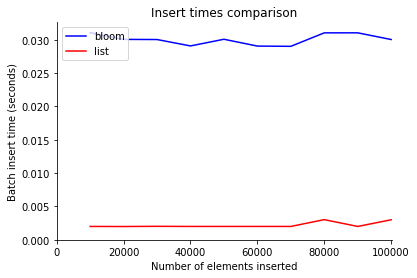

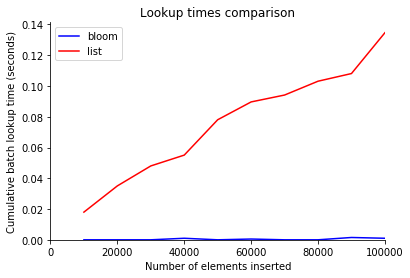

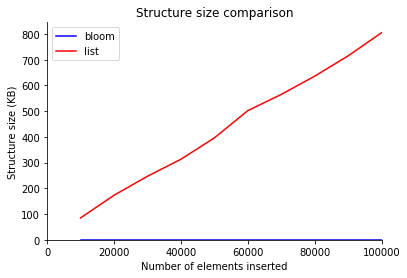

In [13]:
plot_filter_comparison(dict_array_size=100000, batch_steps=10, word_size=32, fp_probability=0.05, words_lookup_per_batch=100)

Bad news is that the **bloom filter insert times are bigger than the list insert times**. This is however not surprising, because on each insert, a number of hash functions have to be calculated for the element to be inserted into the filter. The good news is that the insert times do not increase with the increase of the size of the structure.

On the other hand **the lookup times of the bloom filter are much much shorter than those of the ordinary list**. This is expected, because a bloom filter lookup is a comparison of a couple of hash function results with the corresponding number of bit array elements. While the list lookup requires to scan the whole list to find the actual string. Even worse for the list, the lookup times increase almost linearly with the increase of the structure size, while the bloom filter lookup times remain the same.

Finally as expected **the bloom filter size is much smaller than that of the list and remains the same regardless of how many elements are inserted**. The list size increases linerly with the elements inserted into it.

Now let's perform the same test, but while trying to achive a smaller error rate for the bloom filter:

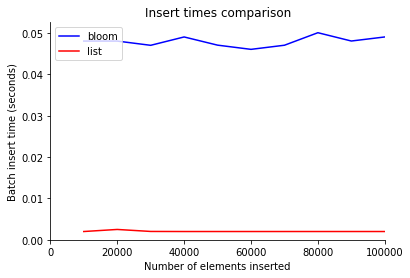

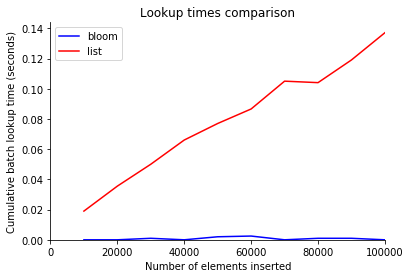

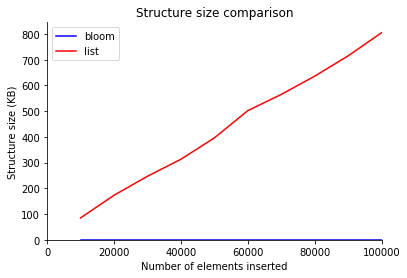

In [17]:
plot_filter_comparison(dict_array_size=100000, batch_steps=10, word_size=32, fp_probability=0.005, words_lookup_per_batch=100)

The insert times of the bloom filter increased slightly, probably due to the bigger number of hash functions calculated, but everything else did not change by much.

Finally let's try a bigger input array of 1 million elements. We may have to wait a bit for that one:

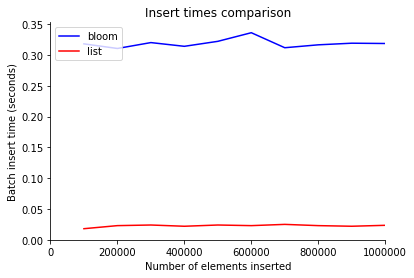

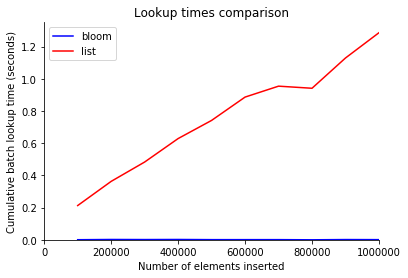

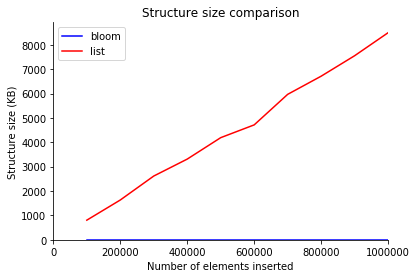

In [18]:
plot_filter_comparison(dict_array_size=1000000, batch_steps=10, word_size=32, fp_probability=0.05, words_lookup_per_batch=100)

Nothing special here. We just prove that our observations are valid even for a much bigger input array. And the growth in size and lookup times for the ordinary list are still linear.

#### Conclusion:
Bloom filter is a much much more space efficient structure than a regular deterministic structure. The lookup times and size of the structure are constant regardless of the number of elements inserted. The only thing that increases when inserting more elements into the filter, is the error rate. The insert times into the bloom filter are a little bit higher than those of a deterministic structure, but this difference is negligible.
An ordinary deterministic structure on the other hand slows down in its search times, when its size increases.
This means that when we want to work with huge amounts of data, where the absolute certainty of correctness is not necessary, a bloom filter is a much much much more efficient structure to use.
When we want to be a 100 percent sure that we will get a correct answer, we are bound to use a deterministic structure. Sometimes a combination of both is the way to go: filter with Bloom filter, then filter further with a normal filter. What makes this possible is that Bloom filter guarantees to not miss any results for you. It can only add false positives, but not false negatives.

### Uses of Bloom filters

As you can imagine, the uses for bloom filters are many and they become even more important with the development of Streaming and Big data technologies. Several examples include Spam filters, Counting filters, Cache filters to prevent "one-hit-wonders". However I want to talk about a very specific use of bloom filters that is not known to many:

#### Bloom filters in an Oracle database

Bloom filters have been used in Oracle since version 10 which was releases more than 10 years ago. However their use is becoming more and more important in the later versions of the database engine, especially in the latest version of Oracle 12. 

They are mainly used to:

* Reduce traffic between parallel slave processes when performing joins
* Replace Subquery partition pruning if desired
* Offload data efficiently in Exadata when joining FACT and DIMENSION tables in a data warehousing environment
* Check existence of data in a server result cache

#### Filtering of data

Let's see how Bloom filters gets created and used by creating FACT and DIMENSION tables and joining them using HASH JOIN with filtering condition on the DIMENSION table. This kind of environment and requirement is very usual and common in data warehousing eco-systems.

```sql
SQL> CREATE TABLE DIMENSION
  (
     col1,
     col2
  ) AS
  SELECT MOD( ROWNUM, 10 ),
         ROWNUM
  FROM   DUAL
  CONNECT BY ROWNUM <= 100;

Table created.

SQL> CREATE TABLE FACT
  (
     col1,
     col2
  ) AS
  SELECT MOD( ROWNUM, 25 ),
         ROWNUM
  FROM   DUAL
  CONNECT BY ROWNUM <= 1000000;

Table created.

SQL> exec dbms_stats.gather_table_stats(USER, 'DIMENSION');

PL/SQL procedure successfully completed.

SQL> exec dbms_stats.gather_table_stats(USER, 'FACT');

PL/SQL procedure successfully completed.
```

Now lets execute the query in parallel and join these two tables along with a filter condition on the DIMENSION table.

```sql
SQL> SELECT /*+ parallel(8) */ count( * )
     FROM   FACT,
            DIMENSION
     WHERE  DIMENSION.col1 = 1 AND
            DIMENSION.col2 = FACT.col2;

  COUNT(*)
----------
       100
```

Pull the execution plan from the cursor cache using dbms_xplan along with ALLSTATS ALL option to get the aggregated statistics from all the parallel slaves and Query Coordinator.

```sql
SQL> select * from table(dbms_xplan.display_cursor(null,null,'ALLSTATS ALL'));

PLAN_TABLE_OUTPUT
-------------------------------------------------------------------------------------------------
SQL_ID  587ty27pjwphu, child number 0
-------------------------------------
SELECT /*+ parallel(8) */ count(*) FROM FACT, DIMENSION WHERE DIMENSION.col1 = 1 AND DIMENSION.col2 = FACT.col2

Plan hash value: 4106007966
-----------------------------------------------------------------------------------------------------
| Id  | Operation                | Name      | Starts | E-Rows |   TQ  |IN-OUT| PQ Distrib | A-Rows |
-----------------------------------------------------------------------------------------------------
|   0 | SELECT STATEMENT         |           |      1 |        |       |      |            |      1 |
|   1 |  SORT AGGREGATE          |           |      1 |      1 |       |      |            |      1 |
|   2 |   PX COORDINATOR         |           |      1 |        |       |      |            |      8 |
|   3 |    PX SEND QC (RANDOM)   | :TQ10000  |      0 |      1 | Q1,00 | P->S | QC (RAND)  |      0 |
|   4 |     SORT AGGREGATE       |           |      4 |      1 | Q1,00 | PCWP |            |      4 |
|*  5 |      HASH JOIN           |           |      4 |    100 | Q1,00 | PCWP |            |    100 |
|   6 |       JOIN FILTER CREATE | :BF0000   |      4 |    100 | Q1,00 | PCWP |            |    400 |
|*  7 |        TABLE ACCESS FULL | DIMENSION |      4 |    100 | Q1,00 | PCWP |            |    400 |
|   8 |       JOIN FILTER USE    | :BF0000   |      4 |   1000K| Q1,00 | PCWP |            |    102 |
|   9 |        PX BLOCK ITERATOR |           |      4 |   1000K| Q1,00 | PCWC |            |    102 |
|* 10 |         TABLE ACCESS FULL| FACT      |     71 |   1000K| Q1,00 | PCWP |            |    102 |
-----------------------------------------------------------------------------------------------------

Predicate Information (identified by operation id):
---------------------------------------------------
   5 - access("DIMENSION"."COL2"="FACT"."COL2")
   7 - filter("DIMENSION"."COL1"=1)
  10 - access(:Z>=:Z AND :Z<=:Z)
       filter(SYS_OP_BLOOM_FILTER(:BF0000,"FACT"."COL2"))

Note
-----
   - Degree of Parallelism is 8 because of hint
```
   
As per the execution plan, **Bloom filter got created at line id 6** for the joining column `COL1` of table `DIMENSION` and the same **Bloom filter got used at line id 8** for the FACT table. Further more if we look at the predicate section we could see a function `SYS_OP_BLOOM_FILTER` has been used when accessing `FACT` table at line id 10. This is where Bloom filter is getting used to filter the data from the large FACT table before it could be processed with the HASH join. Actual rows in the execution plan prove that although `FACT` table is marked for a full table scan, **the records returned from it were filtered down from 1 million to just 102 rows**. But Bloom filter can provide false positive results and thus these false positive results have to be eliminated at a later stage. Here is **when performing a `JOIN` between the two sets at line id 5, the false positive results will be verified**. This concludes that though Bloom filters are an efficient probabilistic algorithm, we still need to have a filtering condition due to chances of false positive results.

In this case the usage of Bloom filter is based on join selectivity estimation along with the total amount of data to be processed. Thus if we want to skip these estimations and take control over the Bloom filter, we can use the hints `PX_JOIN_FILTER/NO_PX_JOIN_FILTER` accordingly. But in some cases if we have very less amount of data to be processed and if we force usage of Bloom filter through hint `PX_JOIN_FILTER` then it may not work.

Let's check what overhead will incur, when we disable Bloom filter usage, using hint `NO_PX_JOIN_FILTER`:

```sql
SQL> SELECT /*+ parallel(8) no_px_join_filter(FACT) */ count( * )
     FROM   FACT,
            DIMENSION
     WHERE  DIMENSION.col1 = 1 AND
            DIMENSION.col2 = FACT.col2;

  COUNT(*)
----------
       100

SQL> select * from table(dbms_xplan.display_cursor(null,null,'ALLSTATS ALL'));

PLAN_TABLE_OUTPUT
---------------------------------------------------------------------------------------------------
SQL_ID  dw58fyg7xdtv6, child number 1
-------------------------------------
SELECT /*+ parallel(8) no_px_join_filter(FACT) */ count(*) FROM FACT,DIMENSION WHERE DIMENSION.col1 = 1 AND DIMENSION.col2 = FACT.col2

Plan hash value: 4252532053
--------------------------------------------------------------- ------------------------------------
| Id  | Operation               | Name      | Starts | E-Rows |   TQ  |IN-OUT| PQ Distrib | A-Rows |
--------------------------------------------------------------- ------------------------------------
|   0 | SELECT STATEMENT        |           |      1 |        |       |      |            |      1 |
|   1 |  SORT AGGREGATE         |           |      1 |      1 |       |      |            |      1 |
|   2 |   PX COORDINATOR        |           |      1 |        |       |      |            |      4 |
|   3 |    PX SEND QC (RANDOM)  | :TQ10000  |      0 |      1 | Q1,00 | P->S | QC (RAND)  |      0 |
|   4 |     SORT AGGREGATE      |           |      4 |      1 | Q1,00 | PCWP |            |      4 |
|*  5 |      HASH JOIN          |           |      4 |    100 | Q1,00 | PCWP |            |    100 |
|*  6 |       TABLE ACCESS FULL | DIMENSION |      4 |    100 | Q1,00 | PCWP |            |    400 |
|   7 |       PX BLOCK ITERATOR |           |      4 |   1000K| Q1,00 | PCWC |            |   1000K|
|*  8 |        TABLE ACCESS FULL| FACT      |     52 |   1000K| Q1,00 | PCWP |            |   1000K|
--------------------------------------------------------------- ------------------------------------

Predicate Information (identified by operation id):
---------------------------------------------------
   5 - access("DIMENSION"."COL2"="FACT"."COL2")
   6 - filter("DIMENSION"."COL1"=1)
   8 - access(:Z>=:Z AND :Z<=:Z)

Note
-----
   - Degree of Parallelism is 8 because of hint
```

As we can see in the execution plan, we processed the complete 1 million rows from table `FACT` without any filtration. This also increases the traffic between parallel query slaves causing direct increase in response times.

#### Bloom filter in Oracle Exadata

Oracle has its own Engineered system, called Exadata. In this engineered system a lot of operations that are performed on the data, can be offloaded to the "smart" storage servers which perform the filtering of the data before it is being returned to the database engine. One of those operations that can be offloaded very efficiently is the bloom filter:

```sql
SQL> SELECT count( * )
     FROM   FACT,
            DIMENSION
     WHERE  DIMENSION.col1 = 1 AND
            DIMENSION.col2 = FACT.col2; 

  COUNT(*)
----------
       100

SQL> select * from table(dbms_xplan.display_cursor(null,null,'ALLSTATS ALL'));

PLAN_TABLE_OUTPUT
-------------------------------------------------------------------------
SQL_ID  adrsj1m9a4mbt, child number 0
-------------------------------------
SELECT count( * ) FROM   FACT, DIMENSION WHERE  DIMENSION.col1 =1 AND DIMENSION.col2 = FACT.col2

Plan hash value: 1328814738
-----------------------------------------------------------------------------
| Id  | Operation                    | Name      | Starts | E-Rows | A-Rows |
-----------------------------------------------------------------------------
|   0 | SELECT STATEMENT             |           |      1 |        |      1 |
|   1 |  SORT AGGREGATE              |           |      1 |      1 |      1 |
|*  2 |   HASH JOIN                  |           |      1 |    100 |    100 |
|   3 |    JOIN FILTER CREATE        | :BF0000   |      1 |    100 |    100 |
|*  4 |     TABLE ACCESS STORAGE FULL| DIMENSION |      1 |    100 |    100 |
|   5 |    JOIN FILTER USE           | :BF0000   |      1 |   1000K|   1614 |
|*  6 |     TABLE ACCESS STORAGE FULL| FACT      |      1 |   1000K|   1614 |
-----------------------------------------------------------------------------

Predicate Information (identified by operation id):
---------------------------------------------------
   2 - access("DIMENSION"."COL2"="FACT"."COL2")
   4 - storage("DIMENSION"."COL1"=1)
       filter("DIMENSION"."COL1"=1)
   6 - storage(SYS_OP_BLOOM_FILTER(:BF0000,"FACT"."COL2"))
       filter(SYS_OP_BLOOM_FILTER(:BF0000,"FACT"."COL2"))
```

Although serially executed, a Bloom filter was created and used here. **At line id 3 Bloom filter got created and used to filter the rows from `FACT` table at line id 5**. In the predicate section we see that Bloom function `SYS_OP_BLOOM_FILTER` is offloaded to the storage server to further reduce the data by filtering it directly on the storage level. We can confirm how much data has been offloaded by measuring metrics through session level statistics. In principle Bloom filters existence in Exadata is dominant as it can be completely processed on the storage system.

#### Bloom filter in database result cache

Bloom filters are used in server side result cache to support lookup of information when a query is ran, to check if the result of the query has already been cached by some other session in the database. If the result is already available then it will be retrieved by the query from the server result cache instead of gathering it from database blocks. This kind of validation is done by the queries using Bloom filters to check the probabability of a result existing in any other database session.

Memory used by Bloom filters is very minimal and negligible as shown below.

```sql
SQL> EXEC DBMS_RESULT_CACHE.MEMORY_REPORT(TRUE);
R e s u l t   C a c h e   M e m o r y   R e p o r t
[Parameters]
Block Size          = 1K bytes
Maximum Cache Size  = 10496K bytes (10496 blocks)
Maximum Result Size = 524K bytes (524 blocks)
[Memory]
Total Memory = 583144 bytes [0.013% of the Shared Pool]
... Fixed Memory = 25208 bytes [0.001% of the Shared Pool]
....... Memory Mgr = 208 bytes
....... Cache Mgr  = 256 bytes
....... Bloom Fltr = 2K bytes
.......  = 4088 bytes
....... RAC Cbk    = 6240 bytes
....... State Objs = 12368 bytes
... Dynamic Memory = 557936 bytes [0.013% of the Shared Pool]
....... Overhead = 131952 bytes
........... Hash Table    = 64K bytes (4K buckets)
........... Chunk Ptrs    = 24K bytes (3K slots)
........... Chunk Maps    = 12K bytes
........... Miscellaneous = 131952 bytes
....... Cache Memory = 416K bytes (416 blocks)
........... Unused Memory = 15 blocks
........... Used Memory = 401 blocks
............... Dependencies = 153 blocks (153 count)
............... Results = 248 blocks
................... SQL     = 67 blocks (67 count)
................... PLSQL   = 4 blocks (4 count)
................... CDB     = 130 blocks (104 count)
................... Invalid = 47 blocks (47 count)

PL/SQL procedure successfully completed.
```

In this case Bloom filter memory footprint is just 2 KB for the purpose of serving Server-side result cache.

### Final conclusion

Bloom filter is a nice probabilistic data structure, which has impressive space and lookup time advantages over deterministic data structures. It is widely used nowadays in cases where we do not need absolute certainty of the positive answer and can live with a small probability for a mistake, while we desperately need fast response times and do not have enough memory to hold the actual data to process. Sometimes probabilistic data structures are not just another option to perform a task - they are the only option to do it.

### References 

* Wikipedia article on [Data structure](https://en.wikipedia.org/wiki/Data_structure)
* Wikipedia article on [Hash table](https://en.wikipedia.org/wiki/Hash_table)
* [Introduction to Probabilistic Data Structures](https://dzone.com/articles/introduction-probabilistic-0)
* Wikipedia article on [Bloom filters](https://en.wikipedia.org/wiki/Bloom_filter)
* [Bloom Filters – Introduction and Python Implementation](https://www.geeksforgeeks.org/bloom-filters-introduction-and-python-implementation/)
* [Creating a Simple Bloom Filter](http://www.maxburstein.com/blog/creating-a-simple-bloom-filter/)
* [Usage of Bloom Filter in Oracle](https://community.toadworld.com/platforms/oracle/w/wiki/11514.usage-of-bloom-filter-in-oracle)